Make video

In [1]:
### INITIALISATION ###

import numpy as np          # fundamental package for scientific computing
import xarray as xr         # data handling
import pop_tools            # to mask region of interest
import gsw                  # compute potential density
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import cmocean.cm as cmo

path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/'
temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/'

file = path + 'vvel_1281.012.nc'

grid_name = 'POP_gx1v7'

#setting up of regional mask
region_defs = {
    'NorthAtlantic':[{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [-20.0, 66.0]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}],
    'MediterraneanSea': [{'match': {'REGION_MASK': [7]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask3d = mask3d.sum('region')

# prepare arrays and dictionaries to store files
start = (68 - 30)*12
end = (90 - 20)*12
len_time = end-start # length of time series

# target sigam levels
sigma_level = [12. , 16. , 20. , 24. , 28. , 28.5 , 29.2 , 29.4 , 29.6 , 29.8 , 30. , 30.2 , 30.4 , 30.6 , 
               30.8 , 31. , 31.2 , 31.4 , 31.6 , 31.8 , 32. , 32.2 , 32.4 , 32.6 , 32.8 , 33. , 33.2 , 33.4 , 
               33.6 , 33.8 , 34. , 34.2 , 34.4 , 34.6 , 34.8 , 35. , 35.2 , 35.4 , 35.6 , 35.8 , 36.1 , 36.2 , 
               36.3 , 36.4 , 36.55, 36.6 , 36.65, 36.7 , 36.72, 36.74, 36.76, 36.78, 36.8 , 36.82, 36.84, 
               36.86, 36.88, 36.9 , 36.92, 36.94, 36.96, 36.98, 37. , 37.02, 37.04, 37.06, 37.08, 37.1 , 
               37.12, 37.14, 37.16, 37.18, 37.2 , 37.25, 37.3 , 37.35, 37.4 , 37.45, 37.6 , 37.7, 37.8 , 
               37.9 , 38. , 39. , 40. , 41. , 42.]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
len_time = 10 # length of time series

### PREPARATION

def density_MOC(ds):

    # define range on pop-grid
    min_lat=110
    max_lat=370
    
    overturning = np.zeros([len(sigma_level), (max_lat-min_lat), len_time])
    
    for t in range(len_time):
        
        # select relevant time step of dataset
        ds_t = ds.isel(time=t)
        # prepare array

        for j in range(min_lat,max_lat):
            # prepare transport array
            sigma_transport = np.zeros(len(sigma_level))

            ### compute velocity transport
            v_transport = (ds_t.VVEL.isel(nlat=j) * ds_t.dz.isel(nlat=j) * ds_t.DXU.isel(nlat=j)).values

            ### get sigma vlaues for selected cross section
            sigma_crossection = ds_t.SIGMA.isel(nlat=j).values

            ### sum over longitudes per sigm bin
            for i in range(len(sigma_level)-1):
                ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i+1]))
                sigma_transport[i] = np.nansum(v_transport[ind])

            ## compute overturning
            overturning[:,j-min_lat, t] = np.cumsum(sigma_transport)[::-1] #* 1e-6
            #overturning[:,j-min_lat, t] = overturning[:,j-min_lat, t][::-1]
        
    return overturning



In [3]:
### COMPUTATION ###
salt = salt_path + 'salt_' + file[-11:]
temp = temp_path + 'temp_' + file[-11:]

# read in file abnd apply mask
ds = xr.open_dataset(file).isel(time=slice(0,10)).where(mask3d == 1)
# load salt data set
ds_salt = xr.open_dataset(salt).isel(time=slice(0,10)).where(mask3d == 1)
# load temp data set
ds_temp = xr.open_dataset(temp).isel(time=slice(0,10)).where(mask3d == 1)

# add salt and temp to ds
ds.update(ds_salt[["SALT"]])
ds.update(ds_temp[["TEMP"]])

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, nlat: 384, nlon: 320,
                             transport_comp: 5, transport_reg: 2, z_t: 60,
                             z_w: 60, time: 10, d2: 2, z_t_150m: 15,
                             z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395,
                             moc_z: 61)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 ...
    ULAT                    (nlat, nlon) float64 ...
    TLONG                   (nlat, nlon) float64 ...
    TLAT                    (nlat, nlon) float64 ...
  * time                    (time) object 1850-02-01 00:00:00 ... 1850-11-01 ...
Dimensions without coordinates: moc_comp, nlat, nlon, transport_comp,
                                transport_reg, d2
Data variables: (12/57)
    moc_components          (moc_comp, nlat, nlon) object nan nan ... nan nan
    transport_components    (transport_comp, nlat, nlon) object nan nan ... nan
    transport_regions       (transport_reg, nlat, nlon) object nan nan ... nan
    dz                      (z_t, nlat, nlon) float32 nan nan nan ... nan nan
    dzw                     (z_w, nlat, nlon) float32 nan nan nan ... nan nan
    KMT                     (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    ...                      ...
    nsurface_t              (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    nsurface_u              (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    time_bound              (time, d2, nlat, nlon) object nan nan ... nan nan
    VVEL                    (time, z_t, nlat, nlon) float32 nan nan ... nan nan
    SALT                    (time, z_t, nlat, nlon) float32 nan nan ... nan nan
    TEMP                    (time, z_t, nlat, nlon) float32 nan nan ... nan nan
Attributes: (12/13)
    title:                     b.e21.BHISTsmbb.f09_g17.LE2-1281.012
    history:                   Wed Dec 28 18:57:55 2022: ncrcat --no_tmp_fl /...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    time_period_freq:          month_1
    model_doi_url:             https://doi.org/10.5065/D67H1H0V
    contents:                  Diagnostic and Prognostic Variables
    ...                        ...
    revision:                  $Id$
    calendar:                  All years have exactly  365 days.
    start_time:                This dataset was created on 2020-12-27 at 19:5...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1

In [4]:
### compute potential density
# Conservative Temperature
CT = gsw.conversions.CT_from_pt(ds.SALT, ds.TEMP)
# Potential density
ds['SIGMA'] = gsw.density.sigma2(ds.SALT, CT)

In [5]:
data = density_MOC(ds)

In [6]:
overturning = data * 1e-12
overturning_2 = np.flipud(data * 1e-12)

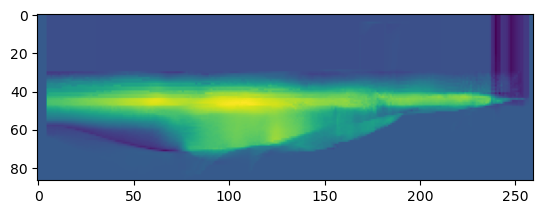

In [7]:
plt.imshow(overturning[:,:,0])

In [8]:
min_lat = 110
max_lat = 370

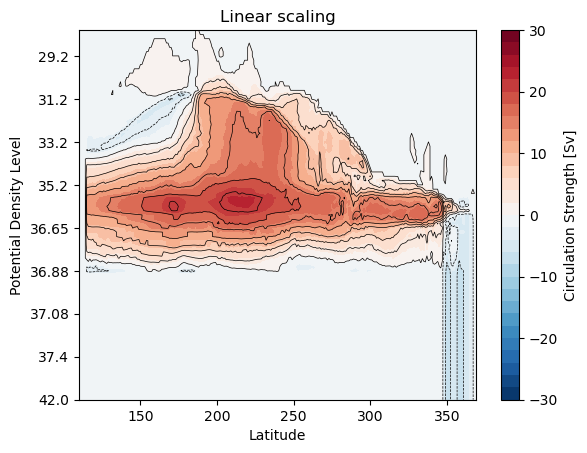

In [10]:
# Your sigma levels
sigma_level = [12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 
               30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4, 
               33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.2, 35.4, 35.6, 35.8, 36.1, 36.2, 
               36.3, 36.4, 36.55, 36.6, 36.65, 36.7, 36.72, 36.74, 36.76, 36.78, 36.8, 36.82, 36.84, 
               36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 
               37.12, 37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 
               37.9, 38., 39., 40., 41., 42.]

# Create figure
fig, ax = plt.subplots()
ax.set_xlabel('Latitude')
ax.set_ylabel('Potential Density Level')
ax.set_title('Linear scaling')

# Adjust the colormap levels and set the center to 0
levels = np.linspace(-30, 30, 31)  # Adjust the range as needed

# Make sure the number of y-axis ticks and labels match the rows in your data (87)
num_rows = 87
ticks_yaxis = np.linspace(0, num_rows - 1, num_rows)
# Choose the step for selecting a subset of sigma_level values as y-axis tick labels
y_axis_step = 10  # Adjust this step value as needed

# Plot data
contour = ax.contourf(np.arange(min_lat, max_lat), ticks_yaxis, overturning[:,:,0], levels=levels, cmap='RdBu_r')
contour_lines = ax.contour(np.arange(min_lat, max_lat), ticks_yaxis, overturning[:,:,0], levels=10, colors='k', linewidths=0.5)

# Create a custom color bar with a centered 0
cbar = plt.colorbar(contour, ax=ax, label='Circulation Strength [Sv]', extend='both')
cbar.set_ticks([-30, -20, -10, 0, 10, 20, 30])  # Adjust the ticks as needed

# Set y ticks
ax.set_yticks(ticks_yaxis[::y_axis_step])
ax.set_yticklabels(sigma_level[::-y_axis_step])

plt.show()

In [11]:
xVAR = np.arange(min_lat, max_lat)
yVAR = np.array(sigma_level)

ticks_axdensvol = np.array([30, 35, 36.1, 36.4, 36.6, 36.8, 36.9, 37, 37.06, 37.1, 37.3])

rounded_yVAR = np.around(yVAR, 2)  # Round to two decimal places

ticks_axdensvol_exact = yVAR[np.in1d(rounded_yVAR, ticks_axdensvol)]


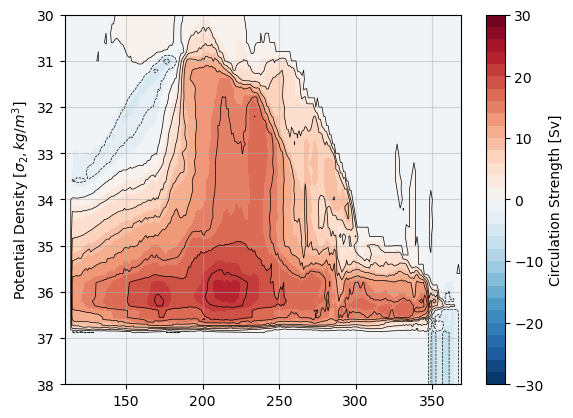

In [12]:
# Define contour levels and colormap
levels = np.linspace(-30, 30, 31)  # Adjust the range as needed
cmap = plt.get_cmap('RdBu_r')

# Create the contour plot
fig, ax = plt.subplots()
contour = ax.contourf(xVAR, yVAR, overturning_2[:,:,0], levels=levels, cmap='RdBu_r')
contour_lines = ax.contour(xVAR, yVAR, overturning_2[:,:,0], levels=10, colors='k', linewidths=0.5)

# Create a custom colorbar with a centered 0
cbar = plt.colorbar(contour, ax=ax, label='Circulation Strength [Sv]', extend='both')
cbar.set_ticks([-30, -20, -10, 0, 10, 20, 30])  # Adjust the ticks as needed

# Set  y axis limits
ax.set_ylim([38, 30])  # Adjust the limits as needed

# Add labels and grid
ax.set_ylabel(r'Potential Density [$\sigma_2, kg/m^3$]')
#ax.set_xlabel(r'Latitude [$^{\circ} N$]')
ax.grid(alpha=0.5)

plt.show()

# VIDEO

In [1]:
### INITIALISATION ###

import xarray as xr
import pop_tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import os                   # to interact with the operating system
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gsw                  # compute potential density

# setting up of regional mask
grid_name = 'POP_gx1v7'
#setting up of regional mask
region_defs = {
    'NorthAtlantic':[{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [-20.0, 66.0]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}],
    'MediterraneanSea': [{'match': {'REGION_MASK': [7]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask3d = mask3d.sum('region')

event_files = ['1281.012.nc', '1301.001.nc', '1281.017.nc', '1231.020.nc', '1281.020.nc', '1281.001.nc']
events = np.array([68,67,44,59,80,154])

temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'
vvel_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/vvel_'

before = 10
after = 10
#period = (before+after)*12
period=10

sigma_level = [12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 
               30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4, 
               33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.2, 35.4, 35.6, 35.8, 36.1, 36.2, 
               36.3, 36.4, 36.55, 36.6, 36.65, 36.7, 36.72, 36.74, 36.76, 36.78, 36.8, 36.82, 36.84, 
               36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 
               37.12, 37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 
               37.9, 38., 39., 40., 41., 42.]

min_lat = 110
max_lat = 370


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
def density_MOC(ds):
    
    overturning = np.zeros([len(sigma_level), (max_lat-min_lat), period])
    
    for t in range(period):
        
        # select relevant time step of dataset
        ds_t = ds.isel(time=t)
        # prepare array

        for j in range(min_lat,max_lat):
            # prepare transport array
            sigma_transport = np.zeros(len(sigma_level))

            ### compute velocity transport
            v_transport = (ds_t.VVEL.isel(nlat=j) * ds_t.dz.isel(nlat=j) * ds_t.DXU.isel(nlat=j)).values

            ### get sigma vlaues for selected cross section
            sigma_crossection = ds_t.SIGMA.isel(nlat=j).values

            ### sum over longitudes per sigm bin
            for i in range(len(sigma_level)-1):
                ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i+1]))
                sigma_transport[i] = np.nansum(v_transport[ind])

            ## compute overturning
            overturning[:,j-min_lat, t] = np.cumsum(sigma_transport)[::-1] #* 1e-6
            #overturning[:,j-min_lat, t] = overturning[:,j-min_lat, t][::-1]
        
    return overturning

In [3]:
i=0

# read in files abnd apply mask
ds = xr.open_dataset(vvel_path+event_files[i]).isel(time=slice(0,10)).where(mask3d == 1)
ds_salt = xr.open_dataset(salt_path+event_files[i]).isel(time=slice(0,10)).where(mask3d == 1)
ds_temp = xr.open_dataset(temp_path+event_files[i]).isel(time=slice(0,10)).where(mask3d == 1)

# add salt and temp to ds
ds.update(ds_salt[["SALT"]])
ds.update(ds_temp[["TEMP"]])

# compute potential density
CT = gsw.conversions.CT_from_pt(ds.SALT, ds.TEMP)
ds['SIGMA'] = gsw.density.sigma2(ds.SALT, CT)

data = density_MOC(ds)
overturning = data * 1e-12

In [20]:
overturning = np.flipud(data * 1e-12)

min_lat = 110
max_lat = 370

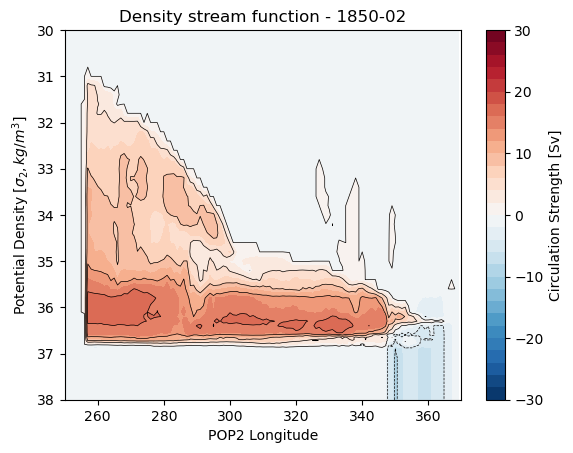

In [30]:
num_frames = 10
interval = 100  # in milliseconds
levels = np.linspace(-30, 30, 31)  # Adjust the range as needed
start=0

fig, ax = plt.subplots()
contour = ax.contourf(np.arange(min_lat, max_lat), sigma_level, overturning[:,:,0], levels=levels, cmap='RdBu_r')
contour_lines = ax.contour(np.arange(min_lat, max_lat), sigma_level, overturning[:,:,0], levels=10, colors='k', linewidths=0.5)



def update(frame):
    ax.clear()
    
    contour = ax.contourf(np.arange(min_lat, max_lat), sigma_level, overturning[:,:,frame], levels=levels, cmap='RdBu_r')
    contour_lines = ax.contour(np.arange(min_lat, max_lat), sigma_level, overturning[:,:,frame], colors='k', linewidths=0.5)
    
    ax.set_ylim([38, 30])
    ax.set_xlim([250, 370])
    
    ax.set_ylabel(r'Potential Density [$\sigma_2, kg/m^3$]')
    ax.set_xlabel('POP2 Longitude')
    
    # create title
    time_values = ds.time.isel(time=start+frame).values
    time_objects = np.array(time_values, dtype='datetime64[ns]')
    date = np.datetime_as_string(time_objects, unit='M')
    plt.title(f'Density stream function - {date}')
    
    #ax.set_title(f'Density stream function - Frame {frame + 1}')

cbar = plt.colorbar(contour, ax=ax, label='Circulation Strength [Sv]', extend='both')
cbar.set_ticks([-30, -20, -10, 0, 10, 20, 30]) 

ani = FuncAnimation(fig, update, frames=num_frames, interval=interval)

# Save the animation as a file (e.g., animation.gif)
ani.save('animation_1.gif', writer='pillow', fps=8)  # Change the filename and format as needed

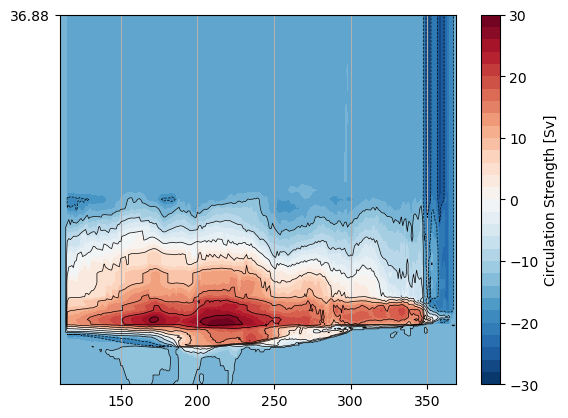

In [19]:
# Create a figure and axis
fig, ax = plt.subplots()
ax.set_ylabel(r'Potential Density [$\sigma_2, kg/m^3$]')
ax.set_xlabel('POP2 Longitude')

ax.set_title('Density stream function')

# Adjust the colormap levels and set the center to 0
levels = np.linspace(-30, 30, 31)  # Adjust the range as needed

# Define the number of frames and time interval between frames
num_frames = 10
interval = 100  # in milliseconds

# Make sure the number of y-axis ticks and labels match the rows in your data (87)
num_rows = 87
ticks_yaxis = np.linspace(0, num_rows - 1, num_rows)
# Choose the step for selecting a subset of sigma_level values as y-axis tick labels
y_axis_step = 10  # Adjust this step value as needed

# Create the initial contour and color bar
contour = ax.contourf(np.arange(min_lat, max_lat), ticks_yaxis, overturning[:,:,0], levels=levels, cmap='RdBu_r')
contour_lines = ax.contour(np.arange(min_lat, max_lat), ticks_yaxis, overturning[:,:,0], levels=10, colors='k', linewidths=0.5)

# Create a custom color bar with a centered 0
cbar = plt.colorbar(contour, ax=ax, label='Circulation Strength [Sv]', extend='both')
cbar.set_ticks([-30, -20, -10, 0, 10, 20, 30])  # Adjust the ticks as needed

# Set y ticks
ax.set_yticks(ticks_yaxis[::y_axis_step])
ax.set_yticklabels(sigma_level[::-y_axis_step])
ax.set_ylim([38, 30])  # Adjust the limits as needed

# Define a function to update the plot for each frame
def update(frame):
    ax.clear()
    # Calculate the data for the current frame (you will need to define this)
    # For example, if you have a function calculate_data(frame) that returns the data for the given frame
    data = overturning[:,:,frame]

    contour = ax.contourf(np.arange(min_lat, max_lat), sigma_level, data, levels=31, cmap='RdBu_r')
    contour_lines = ax.contour(np.arange(min_lat, max_lat), sigma_level, data, levels=10, colors='k', linewidths=0.5)
    ax.grid()
    
    # Set y ticks
    ax.set_yticks(ticks_yaxis[::y_axis_step])
    ax.set_yticklabels(sigma_level[::-y_axis_step])
    ax.set_ylim([38, 30])  # Adjust the limits as needed

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, interval=interval)

# Save the animation as a file (e.g., animation.gif)
ani.save('animation_1.gif', writer='pillow', fps=10)  # Change the filename and format as needed

# Display the animation
#plt.show()